In [4]:
# import cell
import shapefile
import numpy as np
import matplotlib
import pandas as pd
import simpledbf 
from simpledbf import Dbf5

In [5]:
# Read in our shapefile for November 2020
nov_2019_shape = shapefile.Reader("./../data/United_States_Fires/United_States_2019_Fires/nov/United States_fires_nov_2019.shp")
nov_2019_shape_records = nov_2019_shape.shapeRecords()

In [6]:
# Read in our dbf file for November 2000
nov_2019_dbf =  Dbf5('./../data/United_States_Fires/United_States_2019_Fires/nov/United States_fires_nov_2019.dbf')
nov_2019_df = nov_2019_dbf.to_dataframe()

In [7]:
import util
from util import plotPolygons
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.patches import Polygon
import matplotlib as mpl

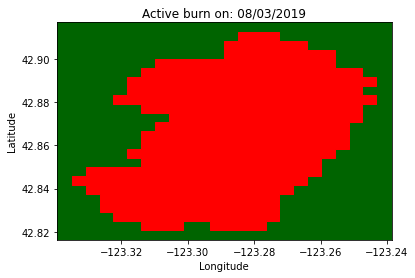

In [8]:
final_fire_date = nov_2019_shape_records[41].record[3]
final_fire_indices = np.array([nov_2019_shape_records[41].shape.points])
plotPolygons([], final_fire_indices, final_fire_date, 1)

In [292]:
def get_grid_representation(xRange, yRange, xDiff, yDiff):
    lonSquares = (xRange[1] - xRange[0])/xDiff
    latSquares = (yRange[1] - yRange[0])/yDiff
    return np.zeros((int(lonSquares), int(latSquares)))

In [293]:
def get_fire_shape_and_discretization(final_fire_indices):
    x_min = float('inf')
    x_max = float('-inf')
    y_min = float('inf')
    y_max = float('-inf')
    for fire in final_fire_indices:
        if fire[0] < x_min:
            x_min = fire[0]
        if fire[1] < y_min:
            y_min = fire[1]
        if fire[0] > x_max:
            x_max = fire[0]
        if fire[1] > y_max:
            y_max = fire[1]

    x_sorted = np.sort([fire[0] for fire in final_fire_indices])
    y_sorted = np.sort([fire[1] for fire in final_fire_indices])
    xdiff = [np.abs(np.subtract(x_sorted[i], x_sorted[i+1])) for i in range(len(x_sorted) - 1)]
    ydiff = [np.abs(np.subtract(y_sorted[i], y_sorted[i+1])) for i in range(len(y_sorted) - 1)]
    xdifflist = np.nonzero(xdiff)[0].astype(int)
    ydifflist = np.nonzero(ydiff)[0].astype(int)
    x_diff = np.min(np.take(xdiff, xdifflist, axis = 0))
    y_diff = np.min(np.take(ydiff, ydifflist, axis = 0))
    #print("X Range: ", (x_min, x_max), "\nY Range: ", (y_min, y_max))
    #print("X Diff: ", x_diff, "\nY Diff: ", y_diff)
    return (x_min, x_max), (y_min, y_max), x_diff, y_diff

In [294]:
def multi_day_fire_initialization(final_fire_indices, number_of_days):
    xRange, yRange, xDiff, yDiff = get_fire_shape_and_discretization(final_fire_indices)
    fireGrid = get_grid_representation(xRange, yRange, xDiff, yDiff).shape
    lonSquares = fireGrid[0]
    latSquares = fireGrid[1]
    return np.zeros((number_of_days, lonSquares, latSquares))
    

In [296]:
xRange, yRange, xDiff, yDiff = get_fire_shape_and_discretization(final_fire_indices[0])
fireGrid = get_grid_representation(xRange, yRange, xDiff, yDiff)

In [297]:
shapeRecord = nov_2019_shape_records[0]

In [299]:
def multi_day_fire_representation(shape_records, sorted_df, final_fire_indices):
 
    multiDayFireGrid = multi_day_fire_initialization(final_fire_indices, sorted_df.IDate.nunique())
    xRange, yRange, xDiff, yDiff = get_fire_shape_and_discretization(final_fire_indices)
    lastFDate = None
    k = -1
    for row in sorted_df.iterrows():
        shape_record = shape_records[row[0]]
        fire_polygon_indices = np.array([shape_record.shape.points])
        polygon = Polygon(fire_polygon_indices[0])
        x_coordinates = np.arange(xRange[0], xRange[1], xDiff)
        y_coordinates = np.arange(yRange[0], yRange[1], yDiff)
        if row[1]['IDate'] != lastFDate:     
            k += 1
            lastFDate = row[1]['IDate']
        path = polygon.get_path()

        for i in range(len(x_coordinates)):
            x = x_coordinates[i]
            for j in range(len(y_coordinates)):
                y = y_coordinates[j]
                point = (x, y)
                if path.contains_point(point, radius = -xDiff):
                    multiDayFireGrid[k][i][j] = 1
    return multiDayFireGrid

In [301]:
multiDayFireGrid = multi_day_fire_representation(nov_2019_shape_records[0:41], sort_by_id(nov_2019_df[0:41], 22266562), nov_2019_shape_records[41].shape.points)
multiDayFireGrid[5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [302]:
def dayToDayProgression2(df, eyeD, shapeRecords):
    # Detailing the day to day progression of a fire
    # It looks like some dates have better data than others, which is interesting. General trends look okay though for a first go around! 
    ID_df = sort_by_id(df,eyeD)
    lastFDate = None
    min_max_day = [float('inf'), float('inf'), -float('inf'), -float('inf')]
    day_index = 2 
    polygon_date_array = []
    polygon_date_dict = {}
    for row in ID_df.iterrows():
        if row[1]['Type'] == 'FinalArea':
            print('Not printing the final Area')
            continue
        feature = shapeRecords[row[0]]
        if row[1]['FDate'] == lastFDate:
            polygon_date_array.append(feature.shape.points) 

        else:
            lastFDate = row[1]['FDate']
            if len(polygon_date_array) == 0:
                continue
            polygon_date_dict[row[1]['FDate']] = polygon_date_array
            polygon_date_array = []
    fig = plt.figure(day_index)
    ax = fig.add_subplot(111)
    polygon_array = []
    day_index = 1
    for date, polygon_indices in polygon_date_dict.items():
        print(date)
        polygon_indices = polygon_date_dict[date]
        plotPolygons(polygon_array, polygon_indices, date, day_index)
        polygon_array.append(polygon_indices)
        day_index += 1

In [65]:

def coordinate_dist_m(coordinate1, coordinate2):
    '''
    Inputs: coordinate1 --> longitude and latitude of c1
            coordinate2 --> longitude and latitude of c2
    Output: Distance (in meters) between those two points based on
    '''
    
    d = np.abs(np.subtract(coordinate1, coordinate2))
    d[0] = d[0] * 111139
    d[1] = d[1] * 111139
    d = np.sqrt(d[0]**2 + d[1]**2)
    return d